# Kalman Filter Tutorial
https://nbviewer.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

## Import Dependencies

In [1]:
import numpy as np
from numpy.random import randn
import math


import plotly as py
import plotly.express as px
from plotly import graph_objects as go

from filterpy import kalman as kf
from filterpy.common import Q_discrete_white_noise


## Multivariate Kalman Filters
https://nbviewer.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

#### compute_dog_data - 1D movement

In [2]:
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

In [3]:
dt = 1.
z_var = 4.   # Sensor variance 
p_var = 2.   # Process variance

In [4]:
x0 = np.array([.0, 1.])  # initial state position and velocity (as mean of normal distr.)
P0 = np.diag([500., 49.]) # initial state covariance, (velocity <= 21m/s: 3σ=21 -> σ²=49)

F = np.array([[1., dt],
              [0., 1]])  # state transition function
Q = Q_discrete_white_noise(dim=2, dt=dt, var=p_var) # process covariance (white noise for movement)
H = np.array([[1., 0.]])   # measurement function, H [x, v] = x
R = np.array([[z_var]])     # measurement variance

### Implement the Kalman Filter

In [5]:
def pos_vel_filter(x, P, R, Q=0, dt=dt):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """ 
    f = kf.KalmanFilter(dim_x=2, dim_z=1)
    f.x = np.array([x[0], x[1]])
    f.F = np.array([[1., dt],
                    [0., 1.]])
    f.H = np.array([[1., 0]])
    f.R *= R
    if np.isscalar(P):
        f.P *= P
    else:
        f.P = P[:]         # [:] makes deep copy
    if np.isscalar(Q):
        f.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        f.Q = Q[:]
    return f


    

In [9]:
f = pos_vel_filter(x=x0, P=P0, R=R, Q=Q, dt=dt)
xs_act, zs = compute_dog_data(z_var=z_var, process_var=p_var, count=20, dt=dt)
f

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 1.]
P = [[500.   0.]
     [  0.  49.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1. 1.]
     [0. 1.]]
Q = [[0.5 1. ]
     [1.  2. ]]
R = [[4.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f21547fc310>

In [10]:
xs=[]
covs=[]
for z in zs:
    f.predict()
    f.update(z)
    xs.append(f.x)
    covs.append(f.P)
xs = np.array(xs)
covs = np.array(covs)

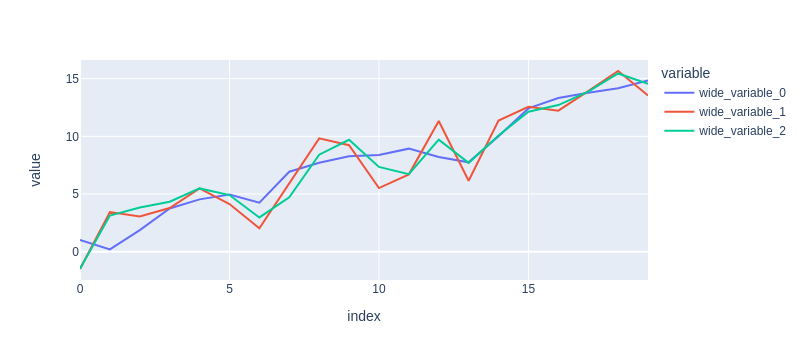

In [11]:
px.line(y=[xs_act, zs, xs[:,0]])

In [84]:
xs_act.shape

(20,)